In [1]:
import warnings
from typing import Tuple, List

import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, validation_curve, learning_curve

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

## Задание 1

In [7]:
data = pd.read_csv("data.csv")
df = data.dropna(axis=1)
df = data[['TransactionAmt','isFraud', 'card1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1']]

In [3]:
x_train, x_valid = train_test_split(
    df.drop(["isFraud"], axis=1), train_size=0.7, shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    df["isFraud"], train_size=0.7, shuffle=True, random_state=1,
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 70000 rows, 17 cols
x_valid.shape = 30000 rows, 17 cols


In [9]:
forest = RandomForestClassifier(
    random_state=27,
#    max_depth=14
)
y_train_pred, y_valid_pred = fit_evaluate_model(
    forest, x_train, y_train, x_valid, y_valid
)

Model Score: train = 0.9998, valid = 0.8984


In [10]:
#Задание 2

In [11]:
model = RandomForestClassifier(random_state=27)
model.fit(x_train, y_train)

RandomForestClassifier(random_state=27)

In [12]:
train_scores, valid_scores = validation_curve(
    X=x_train,
    y=y_train,
    estimator=forest,
    param_range=range(2, 20),
    param_name="max_depth",
    scoring="roc_auc",
    n_jobs=1,
    cv=3,
)

In [13]:
train_score = roc_auc_score(y_train, model.predict_proba(x_train)[:, 1])
valid_score = roc_auc_score(y_valid, model.predict_proba(x_valid)[:, 1])

print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(valid_score, 4)}")

Train-score: 1.0, Valid-score: 0.8984


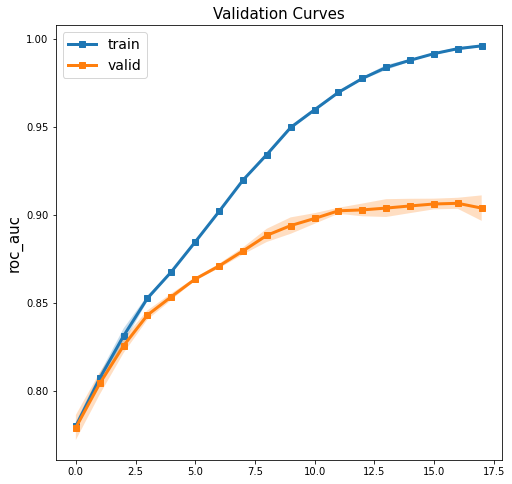

In [16]:
plot_validation_curves(
    train_scores, valid_scores
)

In [ ]:
#Задание 3

In [17]:
forest = RandomForestClassifier(
    random_state=27,
    max_depth=14
)
y_train_pred, y_valid_pred = fit_evaluate_model(
    forest, x_train, y_train, x_valid, y_valid
)

Model Score: train = 0.9714, valid = 0.9078


In [18]:
np.random.seed(27)
scores = create_bootstrap_metrics(
    y_valid, y_valid_pred, roc_auc_score
)

In [19]:
calculate_confidence_interval(scores)

(0.8932272042801874, 0.9220566078980929)

In [5]:
def fit_evaluate_model(estimator, x_train, y_train, x_valid, y_valid):
    """
    Функция для обучения и оценки качества модели.

    Parameters
    ----------
    estimator: callable
        Объект для обучения и применения модели.

    x_train: pandas.DataFrame
        Матрица признаков для обучения модели.

    y_train: pandas.Series
        Вектор целевой переменной для обучения модели.

    x_valid: pandas.DataFrame
        Матрица признаков для валидации модели.

    y_valid: pandas.Series
        Вектор целевой переменной для валидации модели.

    Returns
    -------
    y_train_pred: np.array
        Вектор прогнозов для обучающей выборки

    y_valid_pred: np.array
        Вектор прогнозов для валидационной выборки

    """
    estimator.fit(x_train, y_train)
    y_train_pred = estimator.predict_proba(x_train)[:, 1]
    y_valid_pred = estimator.predict_proba(x_valid)[:, 1]

    train_score = roc_auc_score(y_train, y_train_pred)
    valid_score = roc_auc_score(y_valid, y_valid_pred)
    print(f"Model Score: train = {round(train_score, 4)}, valid = {round(valid_score, 4)}")

    return y_train_pred, y_valid_pred


def plot_validation_curves(train_scores: np.array,
                           valid_scores: np.array,
                           figsize: Tuple[int, int] = (8, 8)
                          ):
    """
    Визуализация процесса настройки гиперпараметра
    алгоритма машинного обучения. Визуализируется значение
    метрики качества на обучащей и тестовой части данных, на
    валидационной части данных и доверительные интервалы.

    Parameters
    ----------
    train_scores: np.array
        Значения метрики качества на обучающей выборке.

    valid_scores: np.array
        Значения метрики качества на валидационной выборке.

    """
    fig = plt.figure(figsize=figsize)

    #plt.subplot(121)
    plt.title("Validation Curves", size=15)
    plt.plot(
        range(train_scores.shape[0]),
        np.mean(train_scores, axis=1),
        label="train",
        linewidth=3,
        marker="s"
    )
    plt.fill_between(
        x=range(train_scores.shape[0]),
        y1=np.mean(train_scores, axis=1)-np.std(train_scores, axis=1),
        y2=np.mean(train_scores, axis=1)+np.std(train_scores, axis=1),
        alpha=0.25
    )
    #plt.subplot(121)
    plt.plot(
        range(train_scores.shape[0]),
        np.mean(valid_scores, axis=1),
        label="valid",
        linewidth=3,
        marker="s"
    )
    plt.fill_between(
        x=range(train_scores.shape[0]),
        y1=np.mean(valid_scores, axis=1)-np.std(valid_scores, axis=1),
        y2=np.mean(valid_scores, axis=1)+np.std(valid_scores, axis=1),
        alpha=0.25
    )
    plt.legend(loc="best", fontsize=14)
    plt.ylabel("roc_auc", size=15)

In [6]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound